## **Setup**

In [1]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U

In [2]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft

In [3]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

## **LoRA Setup**

In [5]:
# We freeze the models weights by setting the requires_grad attribute to False.

for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [6]:
# Prints the number of trainable parameters in the model.

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [7]:
# Setup LoRA Config using peft

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 589824 || all params: 125029632 || trainable%: 0.4717473694555863


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## **Data Loading and Tokenization**

In [8]:
data = []

with open("parsed_quotes_context.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            data.append(concatenated_lines)

In [9]:
len(data)

855

In [10]:
tokenizer.pad_token = tokenizer.eos_token

In [11]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

In [12]:
# To instead load a pretrained model:

# model = GPT2LMHeadModel.from_pretrained("gpt2-sherlock-v0")

## **Training**

In [13]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.550300,4.177370
40,4.540800,4.130270
60,4.187800,4.003134
80,3.965900,3.795523
100,3.802100,3.621745
120,3.551900,3.539822
140,3.636700,3.507981
160,3.527300,3.489424
180,3.657100,3.472597
200,3.450600,3.463485


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=3.534481622457504, metrics={'train_runtime': 437.9814, 'train_samples_per_second': 36.531, 'train_steps_per_second': 2.283, 'total_flos': 652682843873280.0, 'train_loss': 3.534481622457504, 'epoch': 23.39})

## **Sampling**

In [14]:
from transformers import set_seed

set_seed(40)

device = model.device
batch = tokenizer("How would you find who committed the crime, Detective? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How would you find who committed the crime, Detective? ->: _____, that's my cousin, Jack, who's coming in from a business trip to New York. Come here with me -- get yourself a ticket. He's a policeman from the British army who will find out the identity of the culprit soon. Oh? What do you mean? He's named Jack, and he's a member of the Royal family, and he's apparently the oldest member of the Royal Guard. If the man has been caught in a robbery, he'll be charged with homicide


## **Graphs and Visualizations**

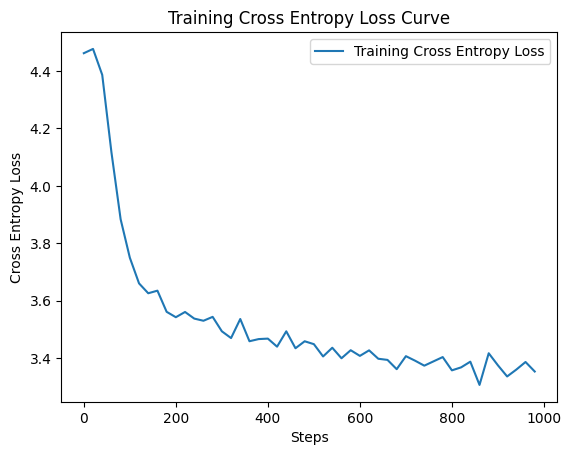

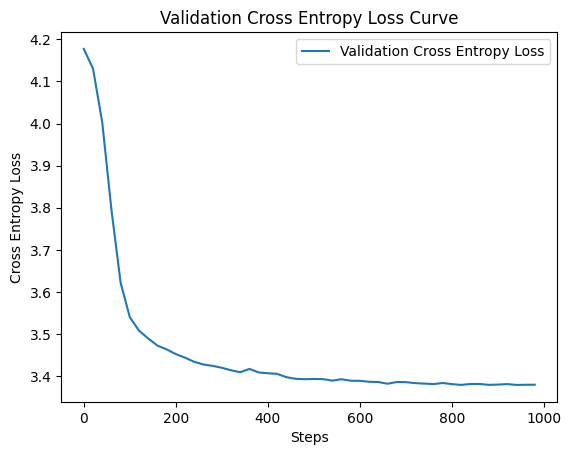

In [16]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve")
plt.legend()
plt.show()

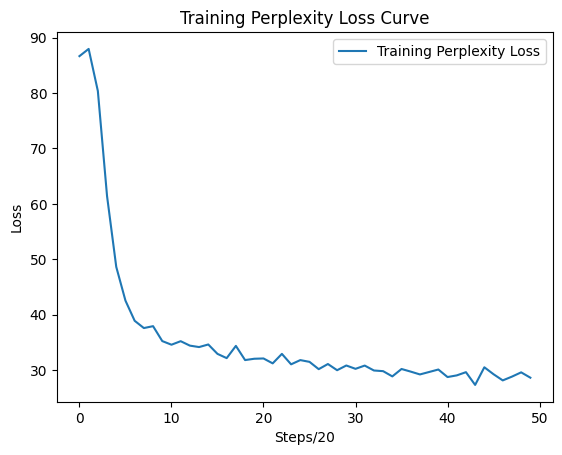

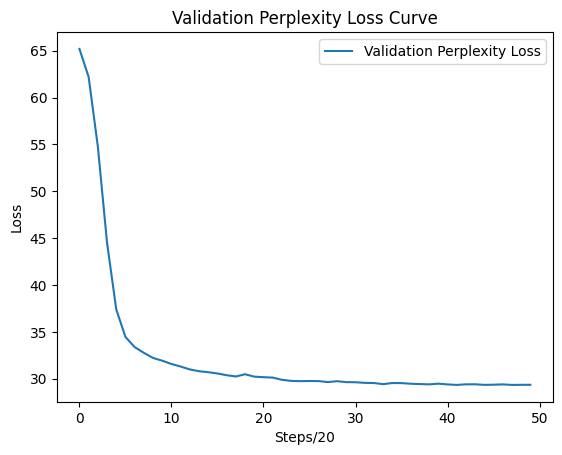

In [17]:
import numpy as np
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]
perplexity_val_loss_values = [np.exp(x) for x in val_loss_values]

# Plot the training loss curve
plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

# Plot the validation loss curve
plt.plot(perplexity_val_loss_values, label="Validation Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Perplexity Loss Curve")
plt.legend()
plt.show()

## **Checkpointed Sampling**

In [18]:
model_250 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-250")

set_seed(40)

device = model_250.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_250.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: -------------------------- What do you mean, Mrs. Hartmann? What do you mean, Holmes? What did you find? What is that? What was it? I suppose that was the one stolen? I shall confess now and show you this picture. It is of the most remarkable colour and deliciously carved shape I have ever seen--a wonderful bird, of course. It has a beautiful bird's nest, very large in its body. The two legs are so slender, my dear, that my imagination has given me the impression it could carry a person. It's really quite remarkable. The bird with the huge legs has had many times its name engraved on it; for instance, Madame Hildegarde; or it could even be used as the name of a family member whose name was also on it. The name of Madame Hildegarde, of course, is 'Hallelujah,' and she was the heroine of this masterpiece of Chinese art. But I 

In [19]:
model_500 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-500")

set_seed(40)

device = model_500.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_500.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: -------------------------- What do you mean, Watson? What do you mean, Mr. Holmes, I suppose you had no clue what I'd done? ->: Oh, well, they came back tomorrow, I suppose. But I've seen them before. It's been the most miserable day of my life. And I suppose there was a promise here that I'd escape. It was as if an old man had offered to get rid of me. But then, I suppose, my disguise doesn't really work so well. What should I do about it? The trickster must've known I was dead. And I suppose the trickster may've been able to find that I'd done something unusual if he'd been able to find a copy of the note, but since he didn't, I suppose I should use this trick to my advantage. This was one of the tricks that Holmes was using in the disguise of his wife, Miss Watson, the mother of the girl missing. But of all the


In [20]:
model_750 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-750")

set_seed(40)

device = model_750.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_750.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: -------------------------- What do you mean, Mrs. Hartmann? What's his name? What is it? Watson? Why do I still have your key? Oh, well, I suppose the key is on my desk now and I suppose this is the key to the bank. And so, if you had the key, there was a robbery here. And so, your guess is as good as mine. It seems to me that perhaps it's a robbery here, in the street, as well. This is Mrs. Hartmann. It is a very dangerous case indeed. Here's a very good case. If I could do that, I'd like to talk to you. Your name and address would be very nice. How long have you been here, Watson? (LAUGHS) I believe it's been a while. Here's your address. I'm a doctor, Watson. Come to the front door. Walk to the front door. Walk carefully past the door, Mr. Johnson


In [21]:
model_0 = GPT2LMHeadModel.from_pretrained("gpt2")

set_seed(40)

device = model_0.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_0.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: ------------ It's possible that they are trying to sneak the thieves in, but we are uncertain how to solve that problem. I'm worried we can't find those culprits in time. If they have time, we can take them in in time. ->: ------------- It's possible to obtain a number in the past, but I suspect they know the number of our next thief. Then we can use any clues we have to solve our case. And even if it's the number of the last one, we can have more confidence. ->: ------------- But, that is, this whole time I'm not thinking about whether it's the last thief, or the last night, or the last weekend, but how long we'll be without the other one. I hope that all these people have some hope that they won't fall victim to the same trick again. The only one that won't. ->: ------- There's a certain feeling about getting used to seein